In [1]:
import numpy as np 
import pandas as pd 
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import cv2 as cv
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import cv2
from tqdm import tqdm

import os

In [2]:
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [4]:
from PIL import Image


In [5]:
import os
from keras.preprocessing import image

In [6]:
categories=['ANGRY' ,'HAPPY' , 'NEUTRAL' , 'SAD']

In [7]:
data=[]
for category in categories:
    path=os.path.join('train',category)
    
    label=categories.index(category)
    
    for file in os.listdir(path):
        img_path=os.path.join(path,file)
        img=cv2.imread(img_path)
        img=cv2.resize(img,(224,224))
        
        data.append([img,label])

In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


In [9]:
test_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_dataset  = train_datagen.flow_from_directory(directory = '../Problem 2 BrainDead/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1810 images belonging to 4 classes.


In [11]:
test_dataset= test_datagen.flow_from_directory(directory = '../Problem 2 BrainDead/Test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 369 images belonging to 4 classes.


In [12]:
import tensorflow as tf

In [13]:
base_model = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

In [15]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [16]:
model = Sequential()
model.add(layers.Flatten(input_shape=(48,48,3)))

In [17]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization()) 
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [18]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [19]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [20]:
from tensorflow.keras.optimizers import Adam

In [21]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [22]:

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [23]:
import keras.backend as K

In [24]:
from keras import backend as K

In [25]:
history=model.fit(train_dataset,validation_data=test_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/10
29/29 [==============================] - 49s 2s/step - loss: 1.4600 - accuracy: 0.7443 - precision: 0.4260 - recall: 0.0652 - auc: 0.5442 - f1_score: 0.1118 - val_loss: 1.9315 - val_accuracy: 0.6917 - val_precision: 0.3464 - val_recall: 0.2629 - val_auc: 0.5940 - val_f1_score: 0.2949 - lr: 0.0010
Epoch 2/10
29/29 [==============================] - 43s 1s/step - loss: 1.4093 - accuracy: 0.7504 - precision: 0.5075 - recall: 0.0558 - auc: 0.5607 - f1_score: 0.0996 - val_loss: 1.3975 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5106 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/10
29/29 [==============================] - 43s 1s/step - loss: 1.3598 - accuracy: 0.7540 - precision: 0.5901 - recall: 0.0525 - auc: 0.5849 - f1_score: 0.0965 - val_loss: 1.3820 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5495 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/10
29/29 [==============================]

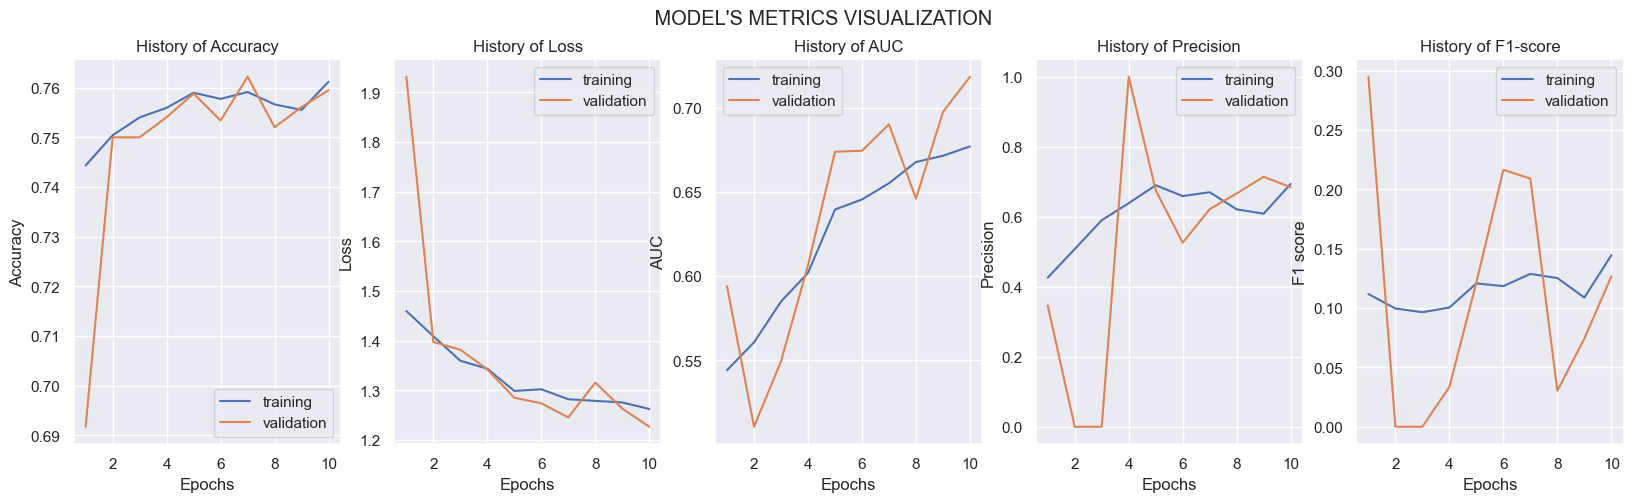

In [26]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )